In [1]:
!pip install mlrose_hiive

In [2]:
import numpy as np
import logging
import time
import string

import matplotlib.pyplot as plt
import mlrose_hiive as mlrose
from mlrose_hiive import QueensGenerator, MaxKColorGenerator, TSPGenerator
from mlrose_hiive import SARunner, GARunner, MIMICRunner, RHCRunner

import warnings
warnings.filterwarnings('ignore')

In [3]:
def queen_max(state):
    fitness = 0
    for i in range(len(state) -1):
        for j in range(i+1, len(state)):
            if (state[j] != state[i]) and (state[j] != state [i] + (j-i)) and (state[j] != state [i] - (j-i)):
                fitness += 1
    return fitness

In [4]:
length = 30
random_state=42
fitness = mlrose.CustomFitness(queen_max)
problem = mlrose.QueensOpt(length,fitness,maximize=True)


In [5]:
def find_best_run(df_curve):
    best_fitness = df_curve[df_curve['Fitness'] == df_curve['Fitness'].max()]
    best_run = best_fitness[best_fitness['FEvals'] == best_fitness['FEvals'].min()].iloc[0]
    if "Restarts" in df_curve:
        rhc_opt_cur = best_run['current_restart']
        rhc_clock = 0
        for i in range(int(rhc_opt_cur+1)):
            rhc_clock +=df_curve[df_curve.current_restart==i].iloc[-1].Time
        best_run["Time"]=rhc_clock
    return best_run


def rhc_run(problem):
    rhc=RHCRunner(problem=problem,
              experiment_name="queens_rhc",
              output_directory=None,
              seed=random_state,
              max_attempts=500,
              iteration_list=[1024],
              restart_list=[10])
    return rhc.run()

def sa_run(problem):
    sa = SARunner(problem=problem,
                  experiment_name='queens_sa',
                  output_directory=None,
                  seed=random_state,
                  iteration_list=[1024],
                  max_attempts=500,
                  temperature_list=[0.1, 0.5, 0.75, 1.0, 2.0, 5.0])
    return sa.run()

def mimic_run(problem):
    mimic = MIMICRunner(problem=problem,
                        experiment_name='queens_mimic',
                        output_directory=None,
                        seed=random_state,
                        population_sizes=[800,900,1000],
                        keep_percent_list=[0.1,0.2,0.3],
                        iteration_list=[50],
                        use_fast_mimic=True)
    return mimic.run()

def ga_run(problem):
    ga = GARunner(problem=problem,
                  experiment_name='queens_ga',
                  output_directory=None,
                  seed=random_state,
                  iteration_list=[1024],
                  population_sizes=[10, 20, 30],
                  mutation_rates=[0.1, 0.2, 0.5])
    return ga.run()


# Simulated Annealing

In [6]:
sa_run_stats, sa_run_curves = sa_run(problem)
sa_best_run = find_best_run(sa_run_curves)
print(sa_best_run)

Iteration           904
Time           0.569079
Fitness           433.0
FEvals           1061.0
Temperature         2.0
max_iters          1024
Name: 5004, dtype: object


In [7]:
sa_opt_temp = sa_best_run['Temperature']
sa_best_iter = sa_run_curves[(sa_run_curves['Temperature']==sa_opt_temp)]

# Random Hill Climb

In [8]:
rhc_run_stats, rhc_run_curves = rhc_run(problem)
rhc_best_run = find_best_run(rhc_run_curves)
print(rhc_best_run)

Iteration           939.000000
Time                  1.637832
Fitness             432.000000
FEvals             2730.000000
Restarts             10.000000
max_iters          1024.000000
current_restart       2.000000
Name: 2680, dtype: float64


In [9]:
rhc_opt_cur = rhc_best_run['current_restart']
rhc_best_iter = rhc_run_curves[(rhc_run_curves['current_restart']==rhc_opt_cur)]

# Genetic Algorithm

In [10]:
ga_run_stats, ga_run_curves = ga_run(problem)
ga_best_run = find_best_run(ga_run_curves)
print(ga_best_run)

Iteration            522.000000
Time                   2.427242
Fitness              434.000000
FEvals             10997.000000
Population Size       20.000000
Mutation Rate          0.200000
max_iters           1024.000000
Name: 4622, dtype: float64


In [11]:
ga_opt_pop = ga_best_run['Population Size']
ga_opt_mut = ga_best_run['Mutation Rate']
ga_best_iter = ga_run_curves[(ga_run_curves['Population Size']==ga_opt_pop)&(ga_run_curves['Mutation Rate']==ga_opt_mut)]

# MIMIC

In [12]:
mimic_run_stats, mimic_run_curves = mimic_run(problem)
mimic_best_run = find_best_run(mimic_run_curves)
print(mimic_best_run)

Iteration                10
Time               5.736991
Fitness               428.0
FEvals               8814.0
use_fast_mimic         True
Population Size         800
Keep Percent            0.2
max_iters                50
Name: 61, dtype: object


In [13]:
mimic_opt_pop = mimic_best_run['Population Size']
mimic_opt_kpc = mimic_best_run['Keep Percent']
mimic_best_iter = mimic_run_curves[(mimic_run_curves['Population Size']==mimic_opt_pop)&(mimic_run_curves['Keep Percent']== mimic_opt_kpc)]

# Comparison algorithms (Fitness vs Iter)


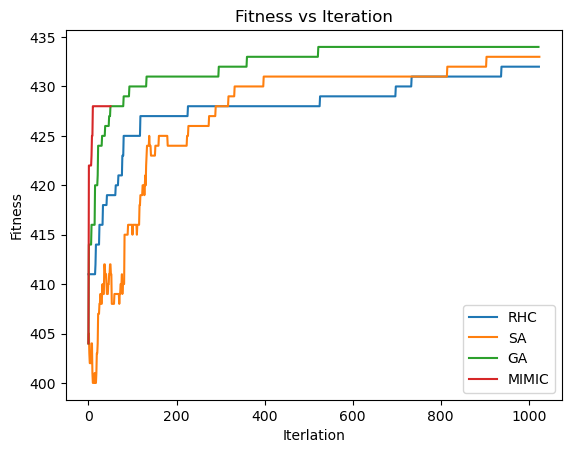

In [14]:
plt.figure()
plt.xlabel("Iterlation")
plt.ylabel("Fitness")
plt.title("Fitness vs Iteration")
plt.plot(range(len(rhc_best_iter)), rhc_best_iter['Fitness'], label="RHC")
plt.plot(range(len(sa_best_iter)), sa_best_iter['Fitness'], label="SA")
plt.plot(range(len(ga_best_iter)), ga_best_iter['Fitness'], label="GA")
plt.plot(range(len(mimic_best_iter)), mimic_best_iter['Fitness'], label="MIMIC")
plt.legend(loc='best')
plt.show()

# Comparison algorithms (Function evals vs Iter)


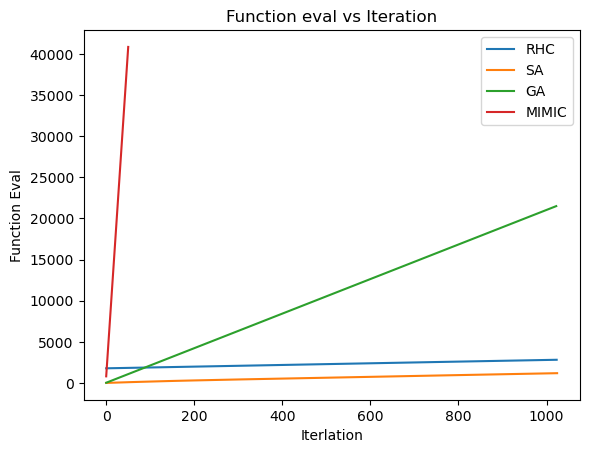

In [15]:
plt.figure()
plt.xlabel("Iterlation")
plt.ylabel("Function Eval")
plt.title("Function eval vs Iteration")
plt.plot(range(len(rhc_best_iter)), rhc_best_iter['FEvals'], label="RHC")
plt.plot(range(len(sa_best_iter)), sa_best_iter['FEvals'], label="SA")
plt.plot(range(len(ga_best_iter)), ga_best_iter['FEvals'], label="GA")
plt.plot(range(len(mimic_best_iter)), mimic_best_iter['FEvals'], label="MIMIC")
plt.legend(loc='best')
plt.show()

# Comparison algorithms (Converge time)

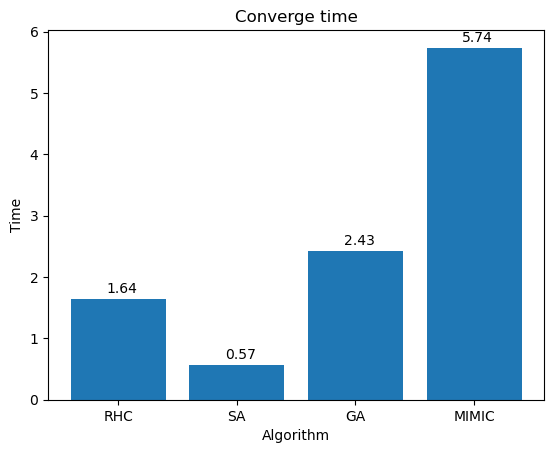

In [16]:
algorithms = ['RHC','SA','GA','MIMIC']
times = [i['Time'] for i in [rhc_best_run,sa_best_run,ga_best_run,mimic_best_run]]
plt.figure()
plt.xlabel("Algorithm")
plt.ylabel("Time")
plt.title("Converge time")
plt.bar(algorithms, times)
for i, v in enumerate(times):
    plt.text(i- 0.1, v+0.1 ,str(round(v,2)))
plt.show()

# Fitness, Wall clock and Fevals by problem size

In [17]:
lengths = range(10,60,10)
runners = [sa_run,rhc_run,ga_run,mimic_run]
algo = ["SA","RHC","GA","MIMIC"]
best_runs=[]
for runner in runners:
    new_problems = [mlrose.DiscreteOpt(length,fitness,maximize=True) for length in lengths]
    best_runs.append([find_best_run(runner(new_problem)[1]) for new_problem in new_problems])

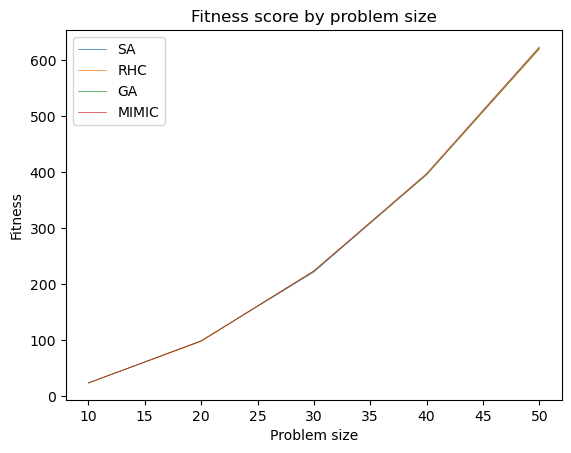

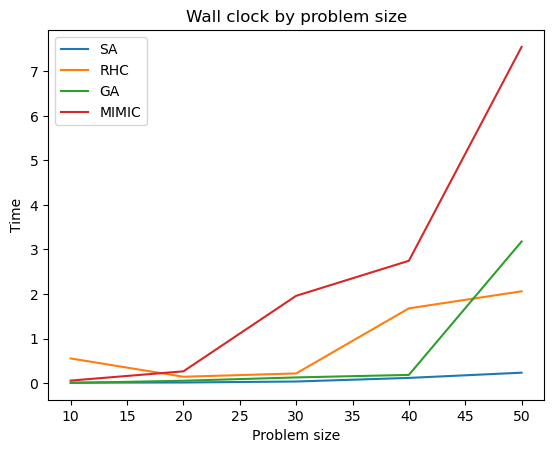

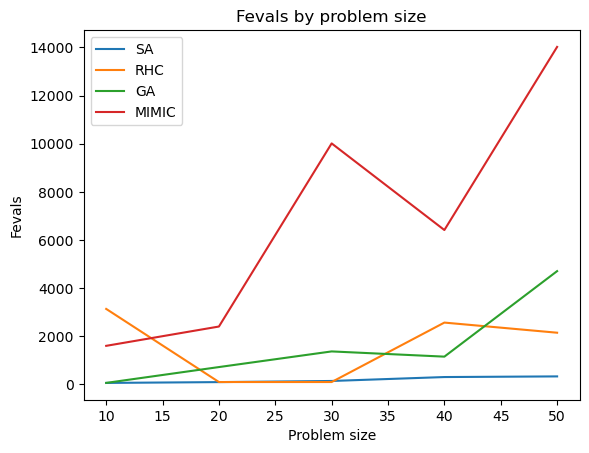

In [25]:
fitnesses = [[length.Fitness for length in learner]for learner in best_runs]
times = [[length.Time for length in learner]for learner in best_runs]
fevals = [[length.FEvals for length in learner]for learner in best_runs]
plt.figure()
plt.xlabel("Problem size")
plt.ylabel("Fitness")
plt.title("Fitness score by problem size")
for i in range(len(algo)):
    plt.plot(lengths, fitnesses[i],label=algo[i], lw=0.5)
plt.legend(loc="best")
plt.show()
plt.figure()
plt.xlabel("Problem size")
plt.ylabel("Time")
plt.title("Wall clock by problem size")
for i in range(len(algo)):
    plt.plot(lengths, times[i],label=algo[i])
plt.legend(loc="best")
plt.show()
plt.figure()
plt.xlabel("Problem size")
plt.ylabel("Fevals")
plt.title("Fevals by problem size")
for i in range(len(algo)):
    plt.plot(lengths, fevals[i],label=algo[i])
plt.legend(loc="best")
plt.show()